[View in Colaboratory](https://colab.research.google.com/github/SakshiPriya/variational-autoencoder/blob/master/vae.ipynb)

In [2]:
!pip install torch
!pip install torchvision

    100% |████████████████████████████████| 519.5MB 30kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5958a000 @  0x7f4ede6001c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 5.6MB/s 
    100% |████████████████████████████████| 2.0MB 12.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [5]:
 !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
 !add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
 !apt-get update -qq 2>&1 > /dev/null
 !apt-get -y install -qq google-drive-ocamlfuse fuse
 from google.colab import auth
 auth.authenticate_user()
 from oauth2client.client import GoogleCredentials
 creds = GoogleCredentials.get_application_default()
 import getpass
 !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
 vcode = getpass.getpass()
 !echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as f
from torchvision import datasets,transforms
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim

In [0]:
transform=transforms.Compose([transforms.ToTensor()])
trainset=datasets.MNIST('drive/app',train=True,download=True,transform=transform)
trainloader=DataLoader(trainset,batch_size=128,shuffle=True,num_workers=2)


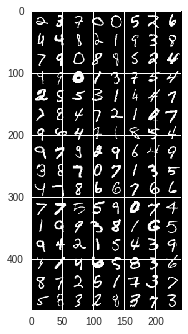

In [4]:
import matplotlib.pyplot as plt
a=iter(trainloader)
def show_img(image):
  untransform=transforms.ToPILImage()
  image=untransform(image)
  plt.imshow(image)
  

plt.figure()
show_img(torchvision.utils.make_grid(a.next()[0]))
plt.show()


In [0]:
class encoder(nn.Module):
  def __init__(self,imsize,hsize,eosize):
    super(encoder,self).__init__()
    self.lin1=nn.Linear(imsize,hsize)
    self.lin2=nn.Linear(hsize,eosize)
  def forward(self,inputs):
    x=torch.sigmoid(self.lin1(inputs))
    x=torch.sigmoid(self.lin2(x))
    return x
             
class decoder(nn.Module):
   def __init__(self,zsize,hsize,dosize):
      super(decoder,self).__init__()
      self.lin1=nn.Linear(zsize,hsize)
      self.lin2=nn.Linear(hsize,dosize)  
   def forward(self,z):
     x=torch.sigmoid(self.lin1(z))
     x=torch.sigmoid(self.lin2(x))
     return x
             

class vae(nn.Module):
  def __init__(self,encoder,decoder,eosize,zsize):
    super(vae,self).__init__()
    self.encoder=encoder
    self.decoder=decoder
    self.mulayer=nn.Linear(eosize,zsize)
    self.sigmalayer=nn.Linear(eosize,zsize)
  def forward(self,image):
     encoderoutput=self.encoder(image)
     latentoutput=self.latentlayer(encoderoutput)
     decoderoutput=self.decoder(latentoutput)
     return decoderoutput
  def latentlayer(self,encoderout):
      mu=self.mulayer(encoderout)
      sigma=self.sigmalayer(encoderout)
      
      reout=self.reparametrization(mu,sigma)
      return reout
  def reparametrization(self,mu,sig):
      
      normalsample=np.random.normal(0,1,size=mu.size())
      normalsample=torch.from_numpy(normalsample).float() 
      logsigma=torch.log(sig)
      musq=mu*mu
      self.latentloss=0.5*torch.mean(1+logsigma-musq-sig)
      return normalsample*sig+mu
      
                      
             


In [0]:
#parameters
lr=0.01
num_epoch=100
imagesize=28*28
hiddensize=256
encoutsize=64
latentsize=16
criterion=nn.MSELoss()
en=encoder(imagesize,hiddensize,encoutsize)
de=decoder(latentsize,hiddensize,imagesize)
aev=vae(en,de,encoutsize,latentsize)



optimizer=optim.Adam(aev.parameters(),lr)

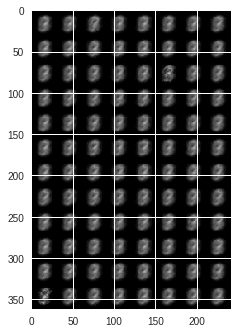

In [28]:
for i in range(num_epoch):
  for batch in trainloader:
    img=batch[0].view(batch[0].size()[0],-1)
    optimizer.zero_grad()
    out=aev(img)
    
    latentloss=aev.latentloss
    
    loss=criterion(out,img)+latentloss
    loss.backward()
    optimizer.step()
    
plt.figure()
out=out.view(out.size()[0],1,28,28)
show_img(torchvision.utils.make_grid(out))
plt.show()